# Analyze Polysome/Monosome
- iteration 8: old data
- iteration 11: new data

# Intersecting with all the eCLIP peaks

In [1]:
import os
import pybedtools
pybedtools.set_bedtools_path('/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/bin/')
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
from plot_params import *
import matplotlib.pyplot as plt
import numpy as np
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper


config = load(open('/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/notebook_protocol/configs/4_EVs.yaml'), Loader=Loader)
basedir = Path(config['workdir'])

if config['circ_de']:
    de_path = list((basedir / 'output/circ_de_reps').glob('*.gtf.tsv'))+list((basedir / 'output/circ_de').glob('*.gtf.tsv'))
#annotation = pd.read_csv('/tscc/nfs/home/hsher/scratch/allcircle/all_circle_annotation.csv')
import pickle
with open('reproducible_EV.pickle', 'rb') as handle:
    reproducible = pickle.load(handle)

In [2]:
gencode = BedTool('/tscc/nfs/home/hsher/gencode_coords/gencode.v35.annotation.gff3').filter(
    lambda x: x[2]=='exon').saveas()


In [3]:
len(gencode)

1398443

In [4]:
def make_circ_interval_bed_exon_only(df):
    df['chrom']=df['circ_id'].str.split(':', expand = True)[0]
    df['start']=df['circ_id'].str.split(':', expand = True)[1].str.split('|', expand = True)[0].astype(int)
    df['end']=df['circ_id'].str.split(':', expand = True)[1].str.split('|', expand = True)[1].astype(int)
    
    circ_only = BedTool.from_dataframe(df[['chrom', 'start', 'end', 'circ_id']])
    
    circ_exons = gencode.intersect(circ_only, f = 1, wb = True)
    
    # rearrange
    
    return circ_exons

In [5]:
eclips = list(Path('/tscc/projects/ps-yeolab5/rbp-portal/encode3/eclip/Skipper/bb63a25/encode_v2/output/finemapping/mapped_sites/').glob(
    '*finemapped_windows.bed.gz'))

In [6]:
len(eclips)

221

In [7]:
annotation = pd.read_csv(basedir / 'output/circle_summary/all_circle_annotation.csv')
indir = Path('/tscc/nfs/home/s5xu/scratch/circSTAMP_pipe/1_basic_nextera/output')
annotation2 = pd.read_csv(indir / 'circle_summary/all_circle_annotation.csv')
annotation = pd.concat([annotation, annotation2], axis = 0).reset_index().drop_duplicates(subset = 'circ_id')

In [8]:
# collect all circle ID and 
all_circs = []
all_tested = {}
all_df = {}
for f in de_path:
    df = pd.read_csv(f, sep = ',', index_col = 0)
    df = df.merge(annotation, left_index = True, right_on = ['circ_id'])
    
    # find all circles
    all_circs += df['circ_id'].tolist()
    # find all tested

    all_df[Path(f).name.replace('.gtf.csv', '')] = df
    
all_circs = pd.DataFrame([set(all_circs)], index = ['circ_id']).T

In [9]:
all_circs.head()

,circ_id
0,chr5:168493894|168495436
1,chr17:39408374|39409951
2,chr7:66441629|66481599
3,chr12:124814791|124815114
4,chr2:95834070|95835098


In [10]:
# make a bed file containing all exons in circle
all_circs_bed = make_circ_interval_bed_exon_only(all_circs)

***** WARNING: File /tmp/pybedtools.z0vweinx.tmp has inconsistent naming convention for record:
GL000195.1	48955	66099	GL000195.1:48955|66099

***** WARNING: File /tmp/pybedtools.z0vweinx.tmp has inconsistent naming convention for record:
GL000195.1	48955	66099	GL000195.1:48955|66099



In [11]:
print(all_circs_bed[0])

chr1	HAVANA	exon	732981	733064	.	-	.	ID=exon:ENST00000648019.1:1;Parent=ENST00000648019.1;gene_id=ENSG00000230021.10;transcript_id=ENST00000648019.1;gene_type=transcribed_processed_pseudogene;gene_name=AL669831.3;transcript_type=processed_transcript;transcript_name=AL669831.3-209;exon_number=1;exon_id=ENSE00003832413.1;level=2;havana_gene=OTTHUMG00000191652.4;havana_transcript=OTTHUMT00000500170.2	chr1	729898	733213	chr1:729898|733213



In [12]:
all_circs_bed = BedTool.from_dataframe(all_circs_bed.to_dataframe(names = 
    ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes']+
                           ['chr', 'circ_start', 'circ_end', 'circ_id']
                          )[['seqname','start', 'end','circ_id']])

In [13]:
# intersect with all eclip
eclip_labels = []
for eclip in eclips:
    eclip_bed = BedTool(eclip)
    try:
        has_peak = all_circs_bed.intersect(eclip_bed).to_dataframe()['name']
    except:
        has_peak = []
    label = all_circs['circ_id'].isin(has_peak)
    label.name = eclip.name.split('.')[0]
    eclip_labels.append(label)
eclip_labels = pd.concat(eclip_labels, axis = 1)
#all_circs.set_index('circ_id', inplace = True)
#all_circs.drop(['chrom', 'start', 'end'], axis = 1, inplace = True)

In [14]:
eclip_labels.index = all_circs['circ_id']

In [15]:
# all_circs.head()

## testing for significant overlap of differentially expressed circles vs eclip binding sites.

### compare DE==0 and DE!=0

In [16]:
from scipy.stats import fisher_exact,chisquare
def testing(df):
    ''' perform fisher exact or chisq given contingency table'''
    if df.shape != (2,2):
        # some outcomes are unobserved
        print(df.shape)
        print('no binding is observed in')
        return 1, np.nan
    if df.le(5).any().any():
        odds_ratio, pvalue = fisher_exact(df)
    else:
        chi, pvalue = chisquare(df.loc[True], (df.loc[True].sum())*df.loc[False].div(df.loc[False].sum()))
        odds_ratio = (df.loc[True, True]/df.loc[True, False])/(df.loc[False, True]/df.loc[False, False])
    return pvalue, odds_ratio

In [17]:
from statsmodels.stats.multitest import fdrcorrection
stats = {}
fdr_thres = 0.2
for name in all_df:
    stat = []
    df = all_df[name]
    df = df.merge(eclip_labels, left_on = 'circ_id', 
                  right_index = True, how = 'left')
    
    # test all eclip
    for rbp in eclip_labels.columns:
        
        pv = pd.pivot_table(df, index = 'DE', columns = rbp,
                            aggfunc = 'size').fillna(0)

        for direction in [1, -1]:
            pv['is_subset']=pv.index==direction
            pvalue, odds = testing(pv.groupby(by = 'is_subset').sum())
            stat.append([rbp, direction, pvalue, odds])
            
    
    stat = pd.DataFrame(stat, columns = ['RBP', 'direction', 'p-value', 'odds_ratio'])
    stat['sig'],stat['FDR'] = fdrcorrection(stat['p-value'], alpha = fdr_thres)
    stats[name] = stat
    
    

(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 1)
no binding is observed in
(1, 1)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 1)
no binding is observed in
(1, 1)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no binding is observed in
(1, 2)
no 

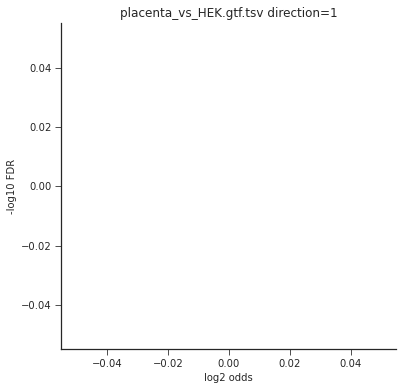

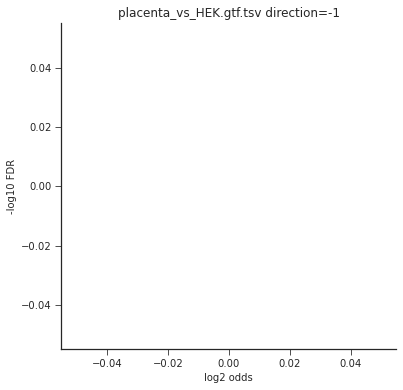

/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/lib/python3.7/site-packages/matplotlib/transforms.py:378: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]
posx and posy should be finite values


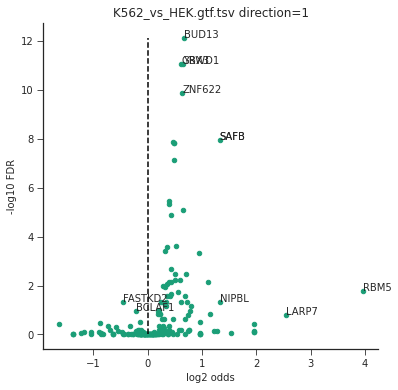

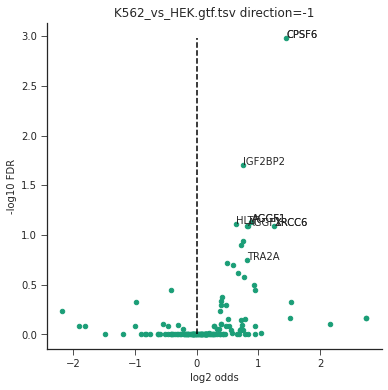

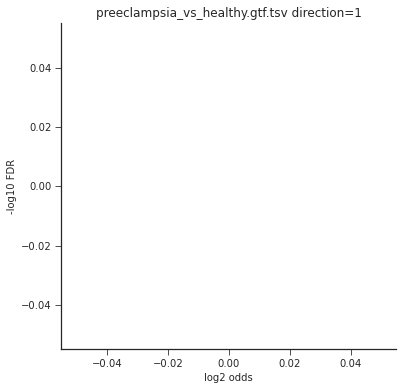

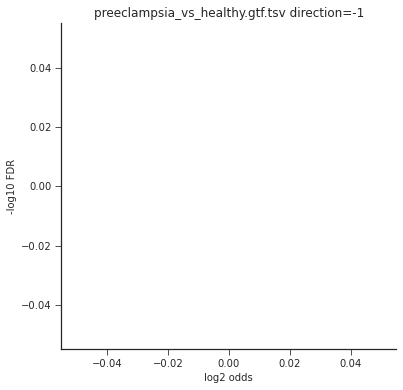

posx and posy should be finite values
posx and posy should be finite values


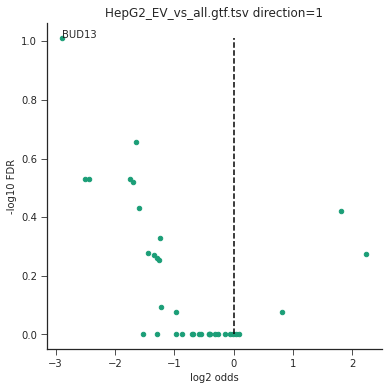

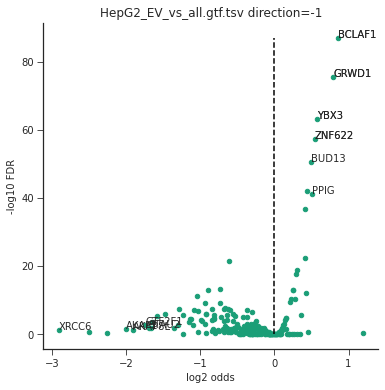

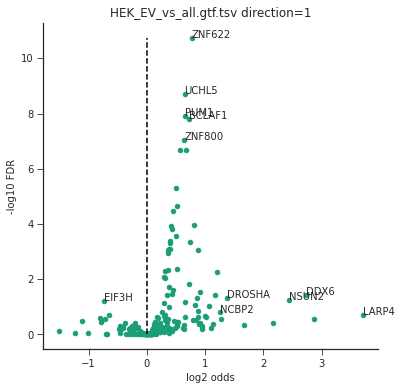

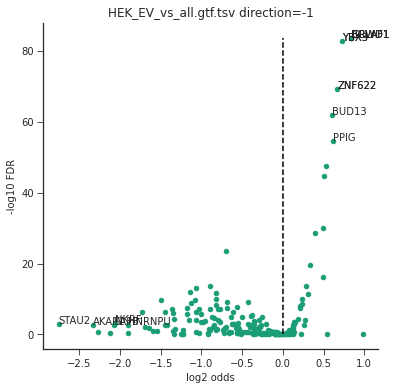

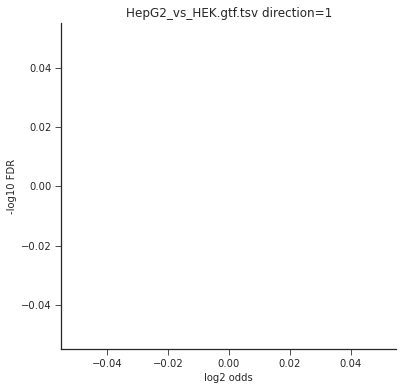

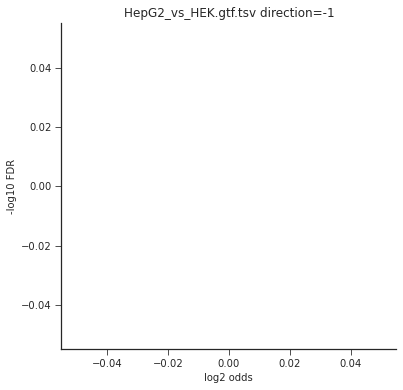

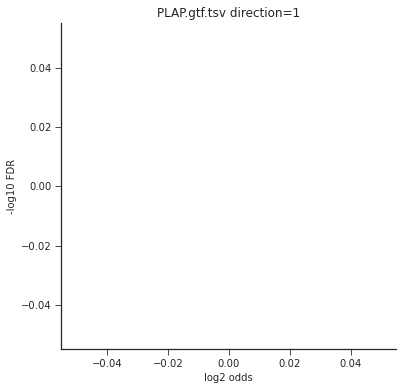

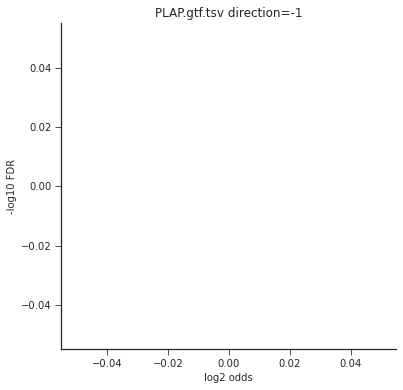

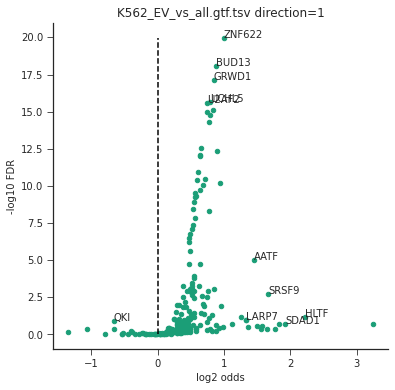

posx and posy should be finite values
posx and posy should be finite values


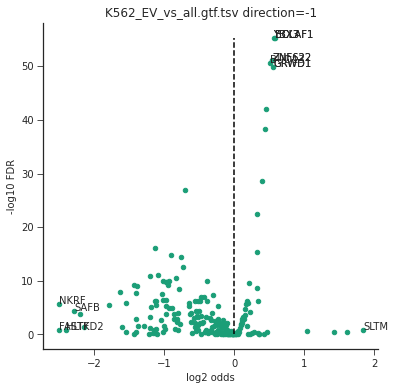

In [18]:
for name in stats:
    alldf = stats[name]
    alldf['-log10 FDR'] = -np.log10(alldf['FDR'])
    alldf['log2 odds'] = np.log2(alldf['odds_ratio'])

    for direction in [1, -1]:
        df = alldf.loc[alldf['direction']==direction]
    
        f, ax = plt.subplots(figsize = (6,6))
        df.plot.scatter(y = '-log10 FDR', x = 'log2 odds', ax = ax)
        k = 5
        top_k_up = df.loc[(df['FDR']<0.2)
                      &(df['odds_ratio']>1)
                      ].sort_values(by = 'odds_ratio', ascending = False).iloc[:k]
        top_k_up_pv = df.loc[(df['FDR']<0.2)
                      &(df['odds_ratio']>1)
                      ].sort_values(by = 'FDR', ascending = True).iloc[:k]
        top_k_down = df.loc[(df['FDR']<0.2)
                      &(df['odds_ratio']<1)
                      ].sort_values(by = 'odds_ratio', ascending = True).iloc[:k]
    
        top_k = pd.concat([top_k_up, top_k_down, top_k_up_pv], axis = 0)
        for index, row in top_k.iterrows():
            ax.text(row['log2 odds'], row['-log10 FDR'], row['RBP'].split('_')[0])
        
        ax.set_title(f'{name} direction={direction}')
        ax.vlines(ymin = df['-log10 FDR'].min(), ymax = df['-log10 FDR'].max(), x = 0,
                 linestyle = '--', color = 'black')
        
        sns.despine()
        plt.show()

In [19]:
#make heatmap
data = []
for subset in ['K562_EV_vs_all.gtf.tsv','HepG2_EV_vs_all.gtf.tsv','HEK_EV_vs_all.gtf.tsv']:
    stat = stats[subset]
    down = stat.loc[(stat['sig'])&(stat['direction']==-1)].set_index('RBP')['odds_ratio']
    up = stat.loc[(stat['sig'])&(stat['direction']==1)].set_index('RBP')['odds_ratio']

    down.name = subset.split('_')[0]+'_EV_depleted'
    up.name = subset.split('_')[0]+'_EV_enriched'
    data += [up, down]
data = pd.concat(data, axis = 1)

In [20]:
data.loc[~data.isnull().all(axis = 1)]

,K562_EV_enriched,K562_EV_depleted,HepG2_EV_enriched,HepG2_EV_depleted,HEK_EV_enriched,HEK_EV_depleted
RBP,,,,,,
TIA1_K562_ENCSR057DWB,1.364514,0.759890,NaN,0.775705,NaN,0.743661
UTP3_K562_ENCSR734ZHL,1.682206,NaN,NaN,NaN,NaN,0.702733
FAM120A_K562_ENCSR006OEQ,1.926744,NaN,NaN,NaN,NaN,NaN
UCHL5_HepG2_ENCSR490IEE,1.456748,1.119902,NaN,1.221259,1.284185,1.215471
KHSRP_K562_ENCSR438GZQ,1.394331,0.926201,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
NSUN2_K562_ENCSR081JYH,NaN,NaN,NaN,NaN,5.446739,NaN
SMNDC1_HepG2_ENCSR373ODC,NaN,NaN,NaN,NaN,NaN,0.531319
TROVE2_HepG2_ENCSR993FMY,NaN,NaN,NaN,NaN,NaN,0.391191


In [21]:
# sns.clustermap(np.log2(data.loc[~data.isnull().all(axis = 1)]).fillna(0), 
#                cmap = 'RdBu_r', metric = 'correlation', vmax = 3, vmin = -3,
#               cbar_kws = {'label': 'l2 odds ratio \n overlapping eCLIP peaks'} 
#               )
# plt.savefig(figdir/'EV_overlap_eCLIP_clustermap.pdf')

In [22]:
data.loc[data[['K562_EV_enriched', 'HepG2_EV_enriched', 'HEK_EV_enriched']].ge(1).all(axis = 1)
&data[['K562_EV_depleted', 'HepG2_EV_depleted', 'HEK_EV_depleted']].le(1).all(axis = 1)]
#odds ratio(stat sig)

,K562_EV_enriched,K562_EV_depleted,HepG2_EV_enriched,HepG2_EV_depleted,HEK_EV_enriched,HEK_EV_depleted
RBP,,,,,,


In [23]:
data.loc[(data[['K562_EV_enriched', 'HepG2_EV_enriched', 'HEK_EV_enriched']].ge(1).sum(axis = 1)>1)
&(data[['K562_EV_depleted', 'HepG2_EV_depleted', 'HEK_EV_depleted']].le(1).sum(axis = 1)>1)]

,K562_EV_enriched,K562_EV_depleted,HepG2_EV_enriched,HepG2_EV_depleted,HEK_EV_enriched,HEK_EV_depleted
RBP,,,,,,
FMR1_K562_ENCSR331VNX,1.299051,0.847548,NaN,0.810073,1.294081,0.869677
DDX6_K562_ENCSR893EFU,1.429149,0.721066,NaN,0.790732,1.649039,0.784583
EFTUD2_K562_ENCSR844RVX,1.249601,0.912519,NaN,0.916277,1.227195,NaN
FXR2_K562_ENCSR224QWC,1.187658,0.890300,NaN,0.845538,1.274205,NaN
TRA2A_HepG2_ENCSR314UMJ,1.242291,0.823752,NaN,0.877462,1.675499,0.785829


In [24]:
data.loc[(data[['K562_EV_enriched', 'HepG2_EV_enriched', 'HEK_EV_enriched']].ge(1).sum(axis = 1)>1)
&(data[['K562_EV_depleted', 'HepG2_EV_depleted', 'HEK_EV_depleted']].ge(1).sum(axis = 1)==0)
].to_csv(figdir / 'EV_overlap_eCLIP_compare_to_nc_filtered.csv')

# Compare to cellular enriched RNA as background.

In [25]:
### compare EV-enriched to cell-enriched
stats_cell_as_bg = {}
fdr_thres = 0.2
for name in all_df:
    stat = []
    df = all_df[name]
    df = df.merge(eclip_labels, left_on = 'circ_id', 
                  right_index = True, how = 'left')
    
    # test all eclip
    for rbp in eclip_labels.columns:
        
        pv = pd.pivot_table(df, index = 'DE', columns = rbp,
                            aggfunc = 'size').fillna(0)

        subset = pv.loc[pv.index.isin([1,-1])]
        subset.rename({1:True, -1:False}, inplace = True)
        pvalue, odds = testing(subset)
        stat.append([rbp, pvalue, odds])
            
    
    stat = pd.DataFrame(stat, columns = ['RBP', 'p-value', 'odds_ratio'])
    stat['sig'],stat['FDR'] = fdrcorrection(stat['p-value'], alpha = fdr_thres)
    stats_cell_as_bg[name] = stat
    

/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 1)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 1)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 1)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no binding is observed in
(0, 2)
no 

/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


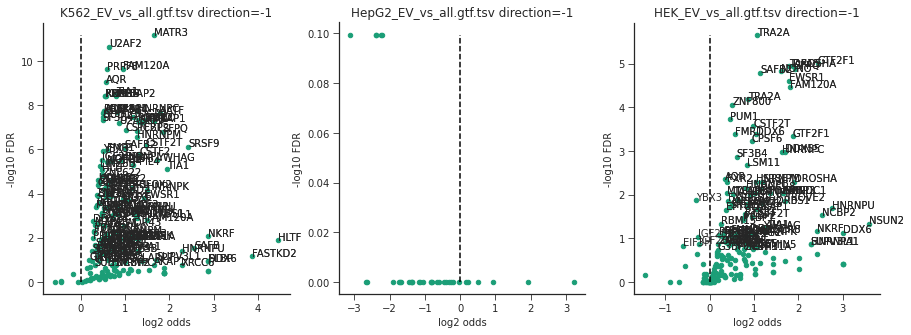

In [26]:
f, axes = plt.subplots(1,3,figsize = (15,5))
for ax,name in zip(axes,['K562_EV_vs_all.gtf.tsv', 'HepG2_EV_vs_all.gtf.tsv','HEK_EV_vs_all.gtf.tsv']):
    df = stats_cell_as_bg[name]
    df['-log10 FDR'] = -np.log10(df['FDR'])
    df['log2 odds'] = np.log2(df['odds_ratio'])

    
    df.plot.scatter(y = '-log10 FDR', x = 'log2 odds', ax = ax)
    
    top_k_up = df.loc[(df['FDR']<0.2)
                  &(df['odds_ratio']>1)
                  ].sort_values(by = 'odds_ratio', ascending = False)
    top_k_up_pv = df.loc[(df['FDR']<0.2)
                  &(df['odds_ratio']>1)
                  ].sort_values(by = 'FDR', ascending = True)
    top_k_down = df.loc[(df['FDR']<0.2)
                  &(df['odds_ratio']<1)
                  ].sort_values(by = 'odds_ratio', ascending = True)

    top_k = pd.concat([top_k_up, top_k_down, top_k_up_pv], axis = 0)
    for index, row in top_k.iterrows():
        ax.text(row['log2 odds'], row['-log10 FDR'], row['RBP'].split('_')[0])
    
    ax.set_title(f'{name} direction={direction}')
    ax.vlines(ymin = df['-log10 FDR'].min(), ymax = df['-log10 FDR'].max(), x = 0,
             linestyle = '--', color = 'black')
    
    sns.despine()
    

In [27]:
data_compare_to_cell_enriched = []
for name in ['K562_EV_vs_all.gtf.tsv','HEK_EV_vs_all.gtf.tsv']:
    stat = stats_cell_as_bg[name]
    
    subset = stat.loc[(stat['sig'])].set_index('RBP')['odds_ratio']
    subset.name = name
    
    data_compare_to_cell_enriched.append(subset)
data_compare_to_cell_enriched = pd.concat(data_compare_to_cell_enriched, axis = 1)

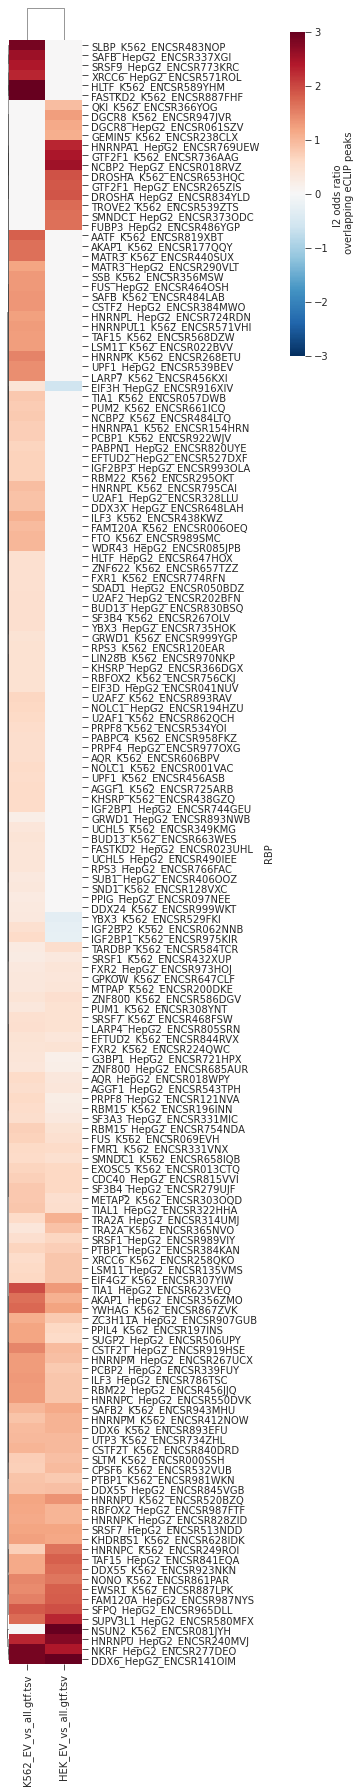

In [28]:
sns.clustermap(np.log2(data_compare_to_cell_enriched.loc[~data_compare_to_cell_enriched.isnull().all(axis = 1)]).fillna(0), 
               cmap = 'RdBu_r', vmax = 3, vmin = -3,
               yticklabels = 1,
               figsize = (4,25),
              cbar_kws = {'label': 'l2 odds ratio \n overlapping eCLIP peaks'} ,
               dendrogram_ratio = 0.02,
               cbar_pos=(1.02, 0.8, 0.05, 0.18)
              )
plt.savefig(figdir/'EV_overlap_eCLIP_clustermap.pdf')

In [54]:
sorted(data_compare_to_cell_enriched.loc[data_compare_to_cell_enriched.isnull().sum(axis = 1)==0].index.tolist())

['AGGF1_HepG2_ENCSR543TPH',
 'AKAP1_HepG2_ENCSR356ZMO',
 'AQR_HepG2_ENCSR018WPY',
 'CDC40_HepG2_ENCSR815VVI',
 'CPSF6_K562_ENCSR532VUB',
 'CSTF2T_HepG2_ENCSR919HSE',
 'CSTF2T_K562_ENCSR840DRD',
 'DDX55_HepG2_ENCSR845VGB',
 'DDX55_K562_ENCSR923NKN',
 'DDX6_HepG2_ENCSR141OIM',
 'DDX6_K562_ENCSR893EFU',
 'EFTUD2_K562_ENCSR844RVX',
 'EIF3H_HepG2_ENCSR916XIV',
 'EIF4G2_K562_ENCSR307YIW',
 'EWSR1_K562_ENCSR887LPK',
 'EXOSC5_K562_ENCSR013CTQ',
 'FAM120A_HepG2_ENCSR987NYS',
 'FMR1_K562_ENCSR331VNX',
 'FUS_K562_ENCSR069EVH',
 'FXR2_HepG2_ENCSR973HOJ',
 'FXR2_K562_ENCSR224QWC',
 'G3BP1_HepG2_ENCSR721HPX',
 'GPKOW_K562_ENCSR647CLF',
 'HNRNPC_HepG2_ENCSR550DVK',
 'HNRNPC_K562_ENCSR249ROI',
 'HNRNPK_HepG2_ENCSR828ZID',
 'HNRNPM_HepG2_ENCSR267UCX',
 'HNRNPM_K562_ENCSR412NOW',
 'HNRNPU_HepG2_ENCSR240MVJ',
 'HNRNPU_K562_ENCSR520BZQ',
 'IGF2BP1_K562_ENCSR975KIR',
 'IGF2BP2_K562_ENCSR062NNB',
 'ILF3_HepG2_ENCSR786TSC',
 'KHDRBS1_K562_ENCSR628IDK',
 'LARP4_HepG2_ENCSR805SRN',
 'LSM11_HepG2_ENCSR135VMS',


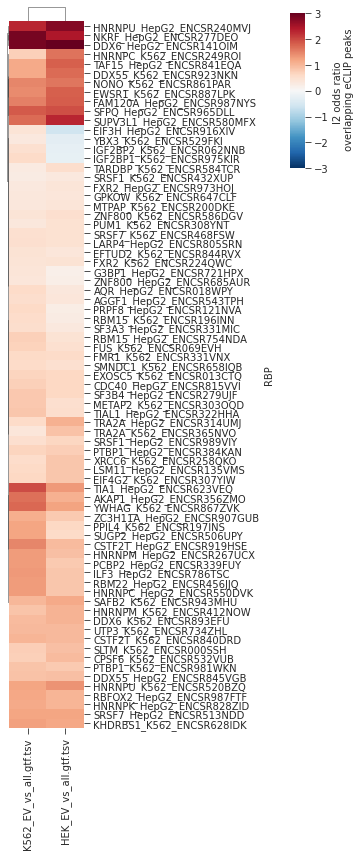

In [29]:
sns.clustermap(np.log2(data_compare_to_cell_enriched.loc[~data_compare_to_cell_enriched.isnull().any(axis = 1)]).fillna(0), 
               cmap = 'RdBu_r', vmax = 3, vmin = -3,
               yticklabels = 1,
               figsize = (4,12),
              cbar_kws = {'label': 'l2 odds ratio \n overlapping eCLIP peaks'} ,
               dendrogram_ratio = 0.02,
               cbar_pos=(1.02, 0.8, 0.05, 0.18)
              )
plt.savefig(figdir/'EV_overlap_eCLIP_clustermap_sigonly.pdf')

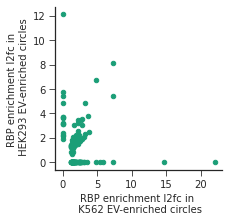

In [42]:
data_compare_to_cell_enriched.fillna(0).plot.scatter(x = 'K562_EV_vs_all.gtf.tsv',
                                           y = 'HEK_EV_vs_all.gtf.tsv',
                                           figsize = (3,3)
                                          )
plt.xlabel('RBP enrichment l2fc in \n K562 EV-enriched circles')
plt.ylabel('RBP enrichment l2fc in \n HEK293 EV-enriched circles')
sns.despine()

In [31]:
data_compare_to_cell_enriched.loc[(data_compare_to_cell_enriched.ge(1).sum(axis = 1)>1)].sort_index()

,K562_EV_vs_all.gtf.tsv,HEK_EV_vs_all.gtf.tsv
RBP,,
AGGF1_HepG2_ENCSR543TPH,1.430831,1.293822
AKAP1_HepG2_ENCSR356ZMO,3.130272,2.110937
AQR_HepG2_ENCSR018WPY,1.486422,1.273621
CDC40_HepG2_ENCSR815VVI,1.645905,1.538254
CPSF6_K562_ENCSR532VUB,1.651126,1.927071
...,...,...
XRCC6_K562_ENCSR258QKO,1.460494,1.793285
YWHAG_K562_ENCSR867ZVK,3.289124,2.318720
ZC3H11A_HepG2_ENCSR907GUB,2.130017,1.716830


In [32]:
data_compare_to_cell_enriched.loc[(data_compare_to_cell_enriched.ge(1).sum(axis = 1)>1)].to_csv(
    figdir / 'EV_overlap_eCLIP_compare_to_cell_enriched_filtered.csv')

In [33]:
rbp_set = set(
    [i.split('_')[0] for i 
     in data_compare_to_cell_enriched.loc[(data_compare_to_cell_enriched.ge(1).sum(axis = 1)>1)].index]
)

In [34]:
_ = [print(i) for i in list(rbp_set)]

CPSF6
SLTM
SUGP2
XRCC6
RBFOX2
SF3B4
SRSF1
CSTF2T
TIA1
YWHAG
METAP2
MTPAP
FMR1
RBM15
EWSR1
LSM11
UTP3
HNRNPU
DDX6
SRSF7
ZC3H11A
TRA2A
GPKOW
EXOSC5
LARP4
TIAL1
NONO
AGGF1
EIF4G2
SAFB2
ZNF800
G3BP1
AKAP1
ILF3
KHDRBS1
HNRNPC
EFTUD2
PUM1
FAM120A
CDC40
FXR2
TAF15
FUS
PTBP1
PPIL4
RBM22
NKRF
PRPF8
PCBP2
DDX55
SFPQ
AQR
TARDBP
SUPV3L1
SF3A3
HNRNPM
HNRNPK
SMNDC1


# HOMER analysis

In [35]:
all_circs

,circ_id,chrom,start,end
0,chr5:168493894|168495436,chr5,168493894,168495436
1,chr17:39408374|39409951,chr17,39408374,39409951
2,chr7:66441629|66481599,chr7,66441629,66481599
3,chr12:124814791|124815114,chr12,124814791,124815114
4,chr2:95834070|95835098,chr2,95834070,95835098
...,...,...,...,...
249432,chr6:107881149|107929514,chr6,107881149,107929514
249433,chr13:100198291|100340259,chr13,100198291,100340259
249434,chr15:83020675|83056545,chr15,83020675,83056545
249435,chr17:36567663|36579419,chr17,36567663,36579419


In [36]:
all_circs_full_bed = make_circ_interval_bed_exon_only(all_circs.index.to_frame())
all_circs_full_bed = all_circs_full_bed.to_dataframe(names = 
    ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes']+
                           ['chr', 'circ_start', 'circ_end', 'circ_id']
                          )

KeyError: 'circ_id'

In [ ]:
all_circs_full_bed['ID'] = all_circs_full_bed['attributes'].str.split(';', expand = True)[0]
cols_to_write = ['ID', 'seqname', 'start', 'end', 'strand']


In [ ]:
outdir = Path('/tscc/nfs/home/hsher/scratch/')
for name in ['K562_EV_vs_all.gtf.tsv', 'HepG2_EV_vs_all.gtf.tsv', 'HEK_EV_vs_all.gtf.tsv']:
    df = all_df[name]
    ev_enriched = df.loc[df['DE']==1, 'circ_id']
    cell_enriched = df.loc[df['DE']==-1, 'circ_id']
    cline = name.split('_')[0]

    foreground_bed=outdir/f'{cline}.ev_enriched.bed'
    background_bed=outdir/f'{cline}.cell_enriched.bed'
    all_circs_full_bed.loc[all_circs_full_bed['circ_id'].isin(ev_enriched), cols_to_write
    ].to_csv(foreground_bed, index = False, header = False, sep = '\t')
    all_circs_full_bed.loc[all_circs_full_bed['circ_id'].isin(cell_enriched), cols_to_write
    ].to_csv(background_bed, index = False, header = False, sep = '\t')
    print(f'''
    mkdir /tscc/nfs/home/hsher/scratch/EV_homer/{cline}
    
    findMotifsGenome.pl \
    {foreground_bed} \
    hg38 \
    /tscc/nfs/home/hsher/scratch/EV_homer/{cline} \
    -size given \
    -bg {background_bed} \
    -rna \
    -len 5,6,7,8,9
    ''')